# Online RL for Statistical Arbitrage with Z-Score Guidance

This notebook implements an online reinforcement learning agent for statistical arbitrage using **Soft Actor-Critic (SAC)** combined with z-score based trading rules.

## 🎯 Hybrid Approach: RL + Rule-Based Trading

The environment combines:
- **Rule-based overrides** at extreme z-scores for safety
- **RL agent learning** in intermediate zones for optimization
- **Continuous action space** for fine-grained position control

### Z-Score Guidance Rules
- **z_score > 1.5**: Force short spread (short asset1, long asset2)
- **z_score < -1.5**: Force long spread (long asset1, short asset2)  
- **|z_score| < 0.5**: Force neutral (close positions)
- **Between thresholds**: SAC agent learns optimal actions

### Key Features
✅ **Online learning** - No offline dataset collection  
✅ **Continuous actions** - Fine-grained position sizing  
✅ **Safety constraints** - Z-score rules prevent failures  
✅ **Interpretable** - Combines classical stat arb with deep RL

### Quick Start
```python
# Create environment
env = make_env_from_mask(train_mask, name="train")

# Train SAC model
model = SAC("MlpPolicy", env)
model.learn(total_timesteps=100000)

# Evaluate
results = backtest_env_sac(test_env, model)
```

## Install Packages

The following libraries are required for this notebook. If you haven't installed them yet, you can do so using running the cell below or by using pip install in your terminal.

In [1]:
# Install required packages including stable-baselines3 for online RL
# Stable-baselines3 >= 2.0.0 has full gymnasium support
%pip install -q -U numpy pandas pyarrow gdown gymnasium torch matplotlib tensorboard "stable-baselines3[extra]>=2.0.0" shimmy[gym]

zsh:1: no matches found: shimmy[gym]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import os
from gdown import download
import math
import random
import pytz
import itertools

from typing import Tuple, Set, Optional, Match
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Reinforcement Learning - Stable-Baselines3 (Online RL)
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
from stable_baselines3.common.monitor import Monitor

# Deep Learning
import torch

print("Imports complete.")

Imports complete.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## Configuration

The configuration section sets up the parameters for the reinforcement learning model.

In [3]:
CONFIG = {
    "DATA": {
        "forward_fill": True,
        "drop_na_after_ffill": True,
        "cache_dir": "./data_cache",
        "timestamp_format": "%Y-%m-%d %H:%M:%S",
        "asset_price_format": "{ASSET}_{FEATURE}",
        "pair_feature_format": "{ASSET1}_{ASSET2}_{FEATURE}",
        "timestamp_col": "timestamp",
        "sampling": "1m",
        "features": {
            "file_id": "1OCqEkOWV73Z8e-67fpqVL3r3ugVcfml8",
            "file_name": "bin_futures_full_features",
            "type": "csv",
            "seperator": ",",
            "index": "datetime",
            "start": "2024-05-01 00:00:00",
            "end": "2025-05-01 00:00:00",
            "individual_identifier": "close",
            "pair_identifier": "beta",
        },
        "prices": {
            "price_folder_id": "1uXEBUyySypdsW_ZqL-RZ3d1bWdIZisij",
            "ADA_1h": "1ydaR3T68ReE_7j5t3wZbj0F-zdRPYoxg",
            "APT_1h": "1CxG9N2bqWPs9fOPOUryYNtHmONXo4SRi",
            "ARB_1h": "136FSMlAW3XHG8WocxxTEcSKiLMUBwWMi",
            "ATOM_1h": "1mhSQgEwRHn3nvu8Qu1ctQGzdW5JuxATR",
            "BTC_1h": "1-sBNQpEFGEpVO3GDFCkSZiV3Iaqp2vB_",
            "DOGE_1h": "14XlkoQMYr8WWecGninAKUavvjB3qNxk0",
            "DOT_1h": "1kCWB4ZZu3FnadbAquTa3Rcdcwkhnq6-s",
            "ENA_1h": "1TYTxexlD24cs7qmhyVoTacX7lqGOsfky",
            "ETC_1h": "1coBd9QiEX03MndMgX5_549mOPyY23ZcI",
            "ETH_1h": "1kj8G1scpFuEYTTXKEUzF9pwgGI2WFFL9",
            "HBAR_1h": "1LVseecBvXKl3Wl9hbPLsROYKR1Gp8zhQ",
            "LINK_1h": "1ZLEraxdV3H8jpf1FmPeVs1ySL7TzMvH5",
            "LTC_1h": "18d3_jD-tuYTQQR2QOwXupckeDgqvAIvx",
            "NEAR_1h": "1PqI2hD2gbDxUaRDPnJpvDNH5wPYv47G6",
            "SOL_1h": "17CjYYSEsTEqBdmm51zGLgmpkslxxjiji",
            "SUI_1h": "1bToOJts-x2Ia48tqXcMs4qFIQ5OV1lAP",
            "TON_1h": "1SARYo5zB6AunG82kw7KGF4Nird3lQ4zB",
            "TRX_1h": "1FlcZo1WRtKFQMbBrsb61Lp3_pplISW4U",
            "UNI_1h": "15L-eKWliyg9MBKuznlZZ-FJzm52Ovt20",
            "WLD_1h": "1XqD1K4-YZzPxYFHKHY3KmKWnnwi3zO20",
            "XLM_1h": "1_3E5-mORLWh3X16Hi0ccHwzVKg5QxoT4",
            "XRP_1h": "1crt2g_t0qpYnaGpcozl35yDeHhd4tmi4"
        }
    },
    "ENV": {
        "include_cash": True,
        "shorting": True,
        "trading_window_days": "2D",
        "sliding_window_step": "1D",
        "lookback_window": 24,
        "transaction_costs": {
            "commission_bps": 4.5,  # Low costs to encourage position taking
            "slippage_bps": 2.0,    # Total: 4 bps
        },
        "reward": {
            "risk_lambda": 0.0001  # Reduced from 0.001 - less penalty for taking positions
        },
        "constraints": {
            "min_weight": -1.0,  # full short
            "max_weight": 1.0,   # full long
            "sum_to_one": True
        },
        # Z-Score Statistical Arbitrage parameters
        "z_score_window": 20,         # Rolling window for z-score calculation
        "z_entry_threshold": 2.0,     # Enter position when |z_score| > 1.5
        "z_exit_threshold": 0.5,      # Exit position when |z_score| < 0.5
        "position_size": 0.5,         # Size of each leg (0.5 = 50% per asset)
        "seed": 42
    },
    "SPLITS": {
        "data_start": "2024-05-01",
        "data_end": "2025-04-30",
        "train": ["2024-05-01", "2024-12-31"],    # ~8 months (70%)
        "val":   ["2025-01-01", "2025-02-28"],    # ~2 months (15%)
        "test":  ["2025-03-01", "2025-04-30"],    # ~2 months (15%)
    },
    "RL": {
        # Online RL with SAC (Stable-Baselines3)
        "algorithm": "SAC",
        "total_timesteps": 1000,  # Total timesteps for online training
        "learning_rate": 3e-4,
        "buffer_size": 100000,  # Replay buffer size
        "learning_starts": 1000,  # Start learning after this many steps
        "batch_size": 256,
        "tau": 0.005,  # Soft update coefficient
        "gamma": 0.99,  # Discount factor
        "train_freq": 1,  # Update the model every N steps
        "gradient_steps": 1,  # Gradient steps per update
        "ent_coef": "auto",  # Entropy coefficient (auto-tuned)
        "target_update_interval": 1,
        "target_entropy": "auto",
    },
    "EVAL": {
        "plots": True,
        "reports_dir": "./reports"
    },
    "IO": {
        "models_dir": "./models",
        "tb_logdir": "./tb_logs",
        "dataset_dir": "./offline_datasets"
    }
}

## Helper Functions

In [4]:
# set annualization factors for different timeframes
ANNUALIZATION = {"1m":365*24*60,
                 "5m":365*24*12,
                 "15m":365*24*4,
                 "1h":365*24,
                 "1d":365}

# create directory if it doesn't already exist
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

## Set Computation Device

This section sets the computation device for training the model. It checks if a GPU is available and sets it as the device; otherwise, it defaults to CPU.

In [5]:
# run on cuda GPU
if torch.cuda.is_available():
    device_str = "cuda"
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

# run on Apple Silicon GPU
elif torch.backends.mps.is_available():
    device_str = "mps"
    device = torch.device("mps")
    print("MPS is available. Using Apple Silicon GPU.")

# run on CPU (slow)
else:
    device_str = "cpu"
    device = torch.device("cpu")
    print("CUDA and MPS are not available. Using CPU.")

MPS is available. Using Apple Silicon GPU.


## Set Seeds

This section sets the random seeds for various libraries to ensure that the results are reproducible.

Note: It is good practice to type (set data types) for function and method parameters for better code maintainability.

In [6]:
def set_all_seeds(seed: int = 42):
    random.seed(seed) # seed for random module
    np.random.seed(seed) # seed for numpy module
    try:
        torch.manual_seed(seed) # seed for torch module
        if torch.cuda.is_available(): # seed for CUDA device
            torch.cuda.manual_seed_all(seed)
        elif torch.backends.mps.is_available(): # seed for Apple Silicon device
            torch.backends.mps.manual_seed_all(seed)
    except Exception:
        pass

set_all_seeds(CONFIG["ENV"]["seed"]) # set all seeds for reproducibility

## Download Feature Data

In this section, we retrieve the .csv file created during feature engineering.

In [7]:
def download_file(file_name: str, file_id: str, out_dir: str):
    ensure_dir(out_dir)

    out_path = os.path.join(out_dir, f"{file_name}.csv")  # full output path

    if os.path.exists(out_path):
        print(f"Skipping download. File {file_name} already exists in cache.")
        return

    try:
        print(f"Downloading {file_name} -> {out_path}")
        url = f"https://drive.google.com/uc?id={file_id}"
        success = download(url, out_path, quiet=False, use_cookies=False, verify=True)
        print("Download complete.")
        return success
    except Exception as e:
        print(f"Download attempt failed for {file_name}. Error: {str(e)}")
    
# donwload features
file_name = CONFIG["DATA"]["features"]["file_name"]
file_id = CONFIG["DATA"]["features"]["file_id"]
cache_dir = CONFIG["DATA"]["cache_dir"]

success = download_file(file_name, file_id, cache_dir)

Skipping download. File bin_futures_full_features already exists in cache.


## Load Feature Data

Once the data is downloaded, this section loads the data into a pandas DataFrame for later processing.

In [8]:
def load_csv_to_df(
    path: str,
    sep: str = ",",
    timestamp_index_col: str | None = "datetime",
    encoding: str = "utf-8-sig",
    **read_csv_kwargs,
) -> pd.DataFrame:
    """
    Load a CSV into a pandas DataFrame.

    Parameters
    ----------
    path : str
        Filesystem path to the CSV.
    parse_timestamp_col : str | None
        If provided and present in the CSV, this column will be parsed to datetime.
        Set to None to skip datetime parsing.
    **read_csv_kwargs :
        Extra arguments passed to `pd.read_csv` (e.g., sep, dtype, usecols).

    Returns
    -------
    pd.DataFrame
    """

    # Parse header-only to check for timestamp col presence
    head = pd.read_csv(path, sep=sep, encoding=encoding, nrows=0)
    if timestamp_index_col and timestamp_index_col in head.columns:
        read_csv_kwargs = {
            **read_csv_kwargs,
            "parse_dates": [timestamp_index_col],
        }

    df = pd.read_csv(path, sep=sep, encoding=encoding, engine="pyarrow", **read_csv_kwargs)

    df = df.set_index("datetime")

    return df


# load features
file_name = CONFIG["DATA"]["features"]["file_name"]
cache_dir = CONFIG["DATA"]["cache_dir"]
index = CONFIG["DATA"]["features"]["index"]
sep = CONFIG["DATA"]["features"].get("seperator", ",")
file_path = os.path.join(cache_dir, f"{file_name}.csv")
features_df = load_csv_to_df(file_path, sep, timestamp_index_col=index)

# print dataframe info
print("Features DataFrame Info:")
print(features_df.info())

Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2024-05-01 00:00:00 to 2025-04-30 23:59:00
Columns: 789 entries, AAVE_close to XRP_fundingMinutesLeft
dtypes: float64(763), int64(25), object(1)
memory usage: 3.1+ GB
None


## Identify Feature Structure

In [9]:
def identify_assets_features_pairs(
    df: pd.DataFrame,
    single_asset_format: str,
    pair_feature_format: str,
) -> Tuple[list[str], list[str], list[str], list[Tuple[str, str]]]:
    """
    Returns distinct
      1. assets
      2. single-asset feature names (ARB_closeUpperShadow → closeUpperShadow)
      3. pair feature names (ARB_ETH_spreadNorm → spreadNorm)
      4. unordered asset pairs
    """

    def format_to_regex(fmt: str) -> re.Pattern:
        escaped = re.escape(fmt)

        def repl(match: Match[str]) -> str:
            name = match.group(1)
            char_class = r"[A-Za-z0-9_]+" if "FEATURE" in name.upper() else r"[A-Za-z0-9]+"
            return f"(?P<{name}>{char_class})"

        escaped = re.sub(r"\\\{(\w+)\\\}", repl, escaped)
        return re.compile(f"^{escaped}$")

    single_asset_pattern = format_to_regex(single_asset_format)
    pair_feature_pattern = format_to_regex(pair_feature_format)
    generic_single_pattern = re.compile(r"^(?P<ASSET>[A-Za-z0-9]+)_(?P<FEATURE>[A-Za-z0-9_]+)$")

    assets: Set[str] = set()
    single_features: Set[str] = set()
    pair_features: Set[str] = set()
    pairs: Set[Tuple[str, str]] = set()

    literal_feature = None
    if "{FEATURE}" not in single_asset_format:
        literal_feature = single_asset_format.replace("{ASSET}", "").lstrip("_")

    skip_cols = {"timestamp", "datetime", "date"}

    for col in df.columns:
        if col in skip_cols:
            continue

        match_pair = pair_feature_pattern.match(col)
        if match_pair:
            a1, a2, feat = match_pair.group("ASSET1"), match_pair.group("ASSET2"), match_pair.group("FEATURE")
            assets.update((a1, a2))
            pairs.add(tuple(sorted((a1, a2))))
            pair_features.add(feat)
            continue

        match_single = single_asset_pattern.match(col)
        if match_single:
            asset = match_single.group("ASSET")
            assets.add(asset)
            feat = match_single.groupdict().get("FEATURE") or literal_feature
            if feat:
                single_features.add(feat)
            continue

        match_generic = generic_single_pattern.match(col)
        if match_generic:
            asset, feat = match_generic.group("ASSET"), match_generic.group("FEATURE")
            assets.add(asset)
            single_features.add(feat)
            continue

    return (
        sorted(assets),
        sorted(single_features),
        sorted(pair_features),
        sorted(pairs),
    )

# identify assets, features, and asset pairs
single_asset_format = CONFIG["DATA"]["asset_price_format"]
pair_feature_format = CONFIG["DATA"]["pair_feature_format"]
assets, single_asset_features, pair_features, asset_pairs = identify_assets_features_pairs(
    features_df,
    CONFIG["DATA"]["asset_price_format"],
    CONFIG["DATA"]["pair_feature_format"],
)

print(f"Identified {len(assets)} assets: {assets}")
print(f"Identified {len(asset_pairs)} asset pairs: {asset_pairs}")
print(f"Identified {len(single_asset_features)} single-asset features: {single_asset_features}")
print(f"Identified {len(pair_features)} pair features: {pair_features}")

Identified 25 assets: ['AAVE', 'ADA', 'APT', 'ARB', 'ATOM', 'AVAX', 'BCH', 'BNB', 'BTC', 'DOGE', 'DOT', 'ENA', 'ETC', 'ETH', 'HBAR', 'LINK', 'LTC', 'NEAR', 'SUI', 'TON', 'TRX', 'UNI', 'WLD', 'XLM', 'XRP']
Identified 61 asset pairs: [('AAVE', 'SUI'), ('AAVE', 'TRX'), ('ADA', 'BTC'), ('ADA', 'DOGE'), ('ADA', 'HBAR'), ('ADA', 'LTC'), ('ADA', 'SUI'), ('ADA', 'XLM'), ('ADA', 'XRP'), ('APT', 'AVAX'), ('ARB', 'ATOM'), ('ARB', 'AVAX'), ('ARB', 'DOT'), ('ARB', 'ETC'), ('ARB', 'ETH'), ('ARB', 'NEAR'), ('ARB', 'WLD'), ('ATOM', 'BCH'), ('ATOM', 'DOT'), ('ATOM', 'ENA'), ('ATOM', 'ETC'), ('AVAX', 'BCH'), ('AVAX', 'DOT'), ('AVAX', 'ETC'), ('AVAX', 'UNI'), ('BCH', 'DOT'), ('BCH', 'ENA'), ('BCH', 'ETC'), ('BNB', 'LINK'), ('BTC', 'DOGE'), ('BTC', 'HBAR'), ('BTC', 'LTC'), ('BTC', 'SUI'), ('BTC', 'TRX'), ('BTC', 'XLM'), ('BTC', 'XRP'), ('DOGE', 'LINK'), ('DOGE', 'LTC'), ('DOGE', 'SUI'), ('DOGE', 'XLM'), ('DOT', 'ENA'), ('DOT', 'ETC'), ('DOT', 'ETH'), ('ENA', 'ETC'), ('ENA', 'UNI'), ('ETC', 'ETH'), ('ETC',

## Build Time Intervals

In [10]:
def build_time_intervals(
    df: pd.DataFrame,
    window: pd.Timedelta | str,
    step: Optional[pd.Timedelta | str] = None,
    timestamp_col: str = "datetime",
    include_last_partial: bool = False,
) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Return fixed-length time intervals over the DataFrame's time span.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime-like 'timestamp' column or have a DatetimeIndex.
    window : pd.Timedelta | str
        Size of each window, e.g. '2D', '60min', '15T'.
    step : pd.Timedelta | str | None
        Step between consecutive window starts. Defaults to `window` (non-overlapping).
        Use a smaller step than `window` for sliding/overlapping windows.
    timestamp_col : str
        Name of the timestamp column (ignored if index is a DatetimeIndex).
    include_last_partial : bool
        If True, include the trailing partial window shorter than `window`.

    Returns
    -------
    list[tuple[pd.Timestamp, pd.Timestamp]]
        Half-open intervals [start, end).
    """
    W = pd.Timedelta(window)
    S = pd.Timedelta(step) if step is not None else W

    # Extract, sanitize, and sort timestamps
    if timestamp_col in df.columns:
        ts = pd.to_datetime(df[timestamp_col]).dropna().sort_values()
    elif isinstance(df.index, pd.DatetimeIndex):
        ts = pd.Series(df.index).dropna().sort_values()
    else:
        raise ValueError(
            f"Timestamp column '{timestamp_col}' not found and index is not DatetimeIndex."
        )

    intervals: list[tuple[pd.Timestamp, pd.Timestamp]] = []
    if ts.empty:
        return intervals

    t_min = ts.iloc[0]
    t_max = ts.iloc[-1]
    cur = t_min

    while cur < t_max:
        end = cur + W
        if end <= t_max:
            intervals.append((cur, end))
        elif include_last_partial:
            intervals.append((cur, t_max))
            break
        else:
            break
        cur = cur + S

    return intervals

# build intervals
window = CONFIG["ENV"]["trading_window_days"]
step = CONFIG["ENV"]["sliding_window_step"]
timestamp_col = CONFIG["DATA"]["timestamp_col"]

intervals = build_time_intervals(
    features_df,
    window,
    step,
    timestamp_col,
    include_last_partial=False
)

# print interval info
print(f"Built {len(intervals)} time intervals with window={window} and step={step}.")
print("First 3 intervals:")
for start, end in intervals[:3]:
    print(f"  {start} to {end}")

Built 363 time intervals with window=2D and step=1D.
First 3 intervals:
  2024-05-01 00:00:00 to 2024-05-03 00:00:00
  2024-05-02 00:00:00 to 2024-05-04 00:00:00
  2024-05-03 00:00:00 to 2024-05-05 00:00:00


## Identify Feature Space

In [11]:
def is_timeframe_valid(
    df: pd.DataFrame,
    pair: tuple[str, str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    feature_name: str,
    pair_feature_format: str = "{ASSET1}_{ASSET2}_{FEATURE}",
    timestamp_col: str | None = "datetime",
) -> bool:
    """
    Check if the given time frame has complete data for the specified asset pair.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    pair : tuple[str, str]
        Asset pair (asset1, asset2).
    start : pd.Timestamp
        Start of the time frame (inclusive).
    end : pd.Timestamp
        End of the time frame (exclusive).
    pair_feature_format : str
        Format string for pair-feature columns (e.g., "{ASSET1}_{ASSET2}_{FEATURE}").
    timestamp_col : str
        Name of the timestamp column.

    Returns
    -------
    bool
        True if the time frame is valid (no missing data), False otherwise.
    """
    feature_col = pair_feature_format.format(
        ASSET1=pair[0], ASSET2=pair[1], FEATURE=feature_name
    )

    if timestamp_col and timestamp_col in df.columns:
        ts = df[timestamp_col]
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame neither has the timestamp column nor a DatetimeIndex."
            )
        ts = df.index

    mask = (ts >= start) & (ts < end)
    if mask.sum() == 0:
        return False

    data_slice = df.loc[mask, feature_col]
    return not data_slice.isna().any()


pair_identifier = CONFIG["DATA"]["features"]["pair_identifier"]

valid_intervals_per_pair = {}
for pair in asset_pairs:
    valid_intervals = []
    for start, end in intervals:
        if is_timeframe_valid(
            features_df,
            pair,
            start,
            end,
            feature_name=pair_identifier,
            pair_feature_format=pair_feature_format,
            timestamp_col=timestamp_col):

            valid_intervals.append((start, end))
    valid_intervals_per_pair[pair] = valid_intervals
    print(f"Pair {pair} has {len(valid_intervals)} valid intervals out of {len(intervals)} total intervals.")

Pair ('AAVE', 'SUI') has 6 valid intervals out of 363 total intervals.
Pair ('AAVE', 'TRX') has 2 valid intervals out of 363 total intervals.
Pair ('AAVE', 'TRX') has 2 valid intervals out of 363 total intervals.
Pair ('ADA', 'BTC') has 6 valid intervals out of 363 total intervals.
Pair ('ADA', 'BTC') has 6 valid intervals out of 363 total intervals.
Pair ('ADA', 'DOGE') has 15 valid intervals out of 363 total intervals.
Pair ('ADA', 'DOGE') has 15 valid intervals out of 363 total intervals.
Pair ('ADA', 'HBAR') has 25 valid intervals out of 363 total intervals.
Pair ('ADA', 'HBAR') has 25 valid intervals out of 363 total intervals.
Pair ('ADA', 'LTC') has 7 valid intervals out of 363 total intervals.
Pair ('ADA', 'LTC') has 7 valid intervals out of 363 total intervals.
Pair ('ADA', 'SUI') has 7 valid intervals out of 363 total intervals.
Pair ('ADA', 'SUI') has 7 valid intervals out of 363 total intervals.
Pair ('ADA', 'XLM') has 9 valid intervals out of 363 total intervals.
Pair ('AD

## Feature Panel Creation

In [12]:
def create_feature_panel(
    df: pd.DataFrame,
    assets: list[str],
    single_asset_features: list[str],
    pair_features: list[str],
    asset_pairs: list[tuple[str, str]],
    pair_feature_format: str,
    timestamp_col: str | None = "datetime",
) -> pd.DataFrame:
    """Assemble a MultiIndex feature panel from pre-normalized inputs."""
    if timestamp_col and timestamp_col in df.columns:
        working_df = df.set_index(timestamp_col)
    else:
        working_df = df
        if not isinstance(working_df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame needs either `timestamp_col` or a DatetimeIndex in order to build the panel."
            )

    panel_columns: list[tuple[str, str]] = []
    panel_series: list[pd.Series] = []

    for asset in assets:
        for feature in single_asset_features:
            col_name = f"{asset}_{feature}"
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((asset, feature))

    for asset1, asset2 in asset_pairs:
        for feature in pair_features:
            col_name = pair_feature_format.format(
                ASSET1=asset1, ASSET2=asset2, FEATURE=feature
            )
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((f"{asset1}_{asset2}", feature))

    if not panel_series:
        raise ValueError("No matching feature columns found to construct the panel.")

    panel = pd.concat(panel_series, axis=1)
    panel.columns = pd.MultiIndex.from_tuples(panel_columns, names=["asset", "feature"])
    return panel.fillna(0)


# Create feature panel
panel = create_feature_panel(
    features_df,
    assets,
    single_asset_features,
    pair_features,
    asset_pairs,
    CONFIG["DATA"]["pair_feature_format"],
)

print("Feature panel structure:")
print("\nShape:", panel.shape)
print("\nSample of the data:")
print(panel.head())

Feature panel structure:

Shape: (525600, 788)

Sample of the data:
asset                    AAVE                                     \
feature                 close closeBias closeEwmaVol closeKalman   
datetime                                                           
2024-05-01 00:00:00  4.423169       0.0          0.0         0.0   
2024-05-01 00:01:00  4.422809       0.0          0.0         0.0   
2024-05-01 00:02:00  4.421368       0.0          0.0         0.0   
2024-05-01 00:03:00  4.422929       0.0          0.0         0.0   
2024-05-01 00:04:00  4.422569       0.0          0.0         0.0   

asset                                                               \
feature             closeLowerShadow closeMacd closeRsi closeSigns   
datetime                                                             
2024-05-01 00:00:00              0.0       0.0      0.0        0.0   
2024-05-01 00:01:00              0.0       0.0      0.0        0.0   
2024-05-01 00:02:00              0.0 

## Feature scaling and state tensor construction

This section normalizes the features and constructs the state tensors required for training the reinforcement learning agent. State tensors are multi-dimensional arrays that represent the current state of the environment that the RL agent uses to make decisions.

In [13]:
def build_state_tensor_for_interval(
        panel: pd.DataFrame,
        pair: tuple,
        start: pd.Timestamp,
        end: pd.Timestamp,
        lookback: int
) -> tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[pd.DatetimeIndex]]:
    """Build state tensor for a specific time interval and asset pair."""
    asset1, asset2 = pair
    pair_str = f"{asset1}_{asset2}"

    # Build consistent column ordering: asset1 features, asset2 features, then pair features
    asset1_columns = sorted([col for col in panel.columns if col[0] == asset1], key=lambda x: x[1])
    asset2_columns = sorted([col for col in panel.columns if col[0] == asset2], key=lambda x: x[1])
    pair_columns = sorted([col for col in panel.columns if col[0] == pair_str], key=lambda x: x[1])
    selected_columns = asset1_columns + asset2_columns + pair_columns

    if not selected_columns:
        return None, None, None, None, None

    # Convert index to DatetimeIndex if it isn't already
    if not isinstance(panel.index, pd.DatetimeIndex):
        if 'datetime' in panel.columns:
            panel = panel.set_index('datetime')
        else:
            raise ValueError("Panel must have either a DatetimeIndex or a 'datetime' column")

    # Ensure index is timezone-aware UTC
    if panel.index.tz is None:
        panel.index = panel.index.tz_localize('UTC')
    elif panel.index.tz != pytz.UTC:
        panel.index = panel.index.tz_convert('UTC')

    start_ts = pd.Timestamp(start)
    end_ts = pd.Timestamp(end)
    if start_ts.tzinfo is None:
        start_ts = start_ts.tz_localize('UTC')
    else:
        start_ts = start_ts.tz_convert('UTC')
    if end_ts.tzinfo is None:
        end_ts = end_ts.tz_localize('UTC')
    else:
        end_ts = end_ts.tz_convert('UTC')

    # Create mask for time window (half-open interval)
    mask = (panel.index >= start_ts) & (panel.index < end_ts)
    window_data = panel.loc[mask, selected_columns]

    if len(window_data) < lookback + 1:
        return None, None, None, None, None

    pair_identifier = CONFIG["DATA"]["features"]["pair_identifier"]
    individual_identifier = CONFIG["DATA"]["features"]["individual_identifier"]

    pair_identifier_key = (pair_str, pair_identifier)
    asset1_price_key = (asset1, individual_identifier)
    asset2_price_key = (asset2, individual_identifier)

    required_keys = (pair_identifier_key, asset1_price_key, asset2_price_key)
    if any(key not in selected_columns for key in required_keys):
        return None, None, None, None, None

    # Prepare dimensions
    n_samples = len(window_data) - lookback
    if n_samples <= 0:
        return None, None, None, None, None

    n_features = len(selected_columns)

    # Initialize tensors
    X = np.zeros((n_samples, 1, n_features, lookback), dtype=np.float32)
    R = np.zeros((n_samples, 1), dtype=np.float32)
    VOL = np.zeros((n_samples, 1), dtype=np.float32)
    asset_returns = np.zeros((n_samples, 2), dtype=np.float32)

    data_values = window_data.values
    feature_to_idx = {col: idx for idx, col in enumerate(selected_columns)}
    asset1_idx = feature_to_idx[asset1_price_key]
    asset2_idx = feature_to_idx[asset2_price_key]

    eps = 1e-12
    asset1_values = data_values[:, asset1_idx].astype(np.float64)
    asset2_values = data_values[:, asset2_idx].astype(np.float64)

    for t in range(n_samples):
        X[t, 0, :, :] = data_values[t:t + lookback].T

        curr_a1 = asset1_values[t + lookback - 1]
        next_a1 = asset1_values[t + lookback]
        curr_a2 = asset2_values[t + lookback - 1]
        next_a2 = asset2_values[t + lookback]

        ret_a1 = (next_a1 - curr_a1) / (abs(curr_a1) + eps)
        ret_a2 = (next_a2 - curr_a2) / (abs(curr_a2) + eps)
        asset_returns[t, 0] = ret_a1
        asset_returns[t, 1] = ret_a2

        pair_step_return = ret_a1 - ret_a2
        R[t, 0] = pair_step_return

        window_a1 = asset1_values[t:t + lookback + 1]
        window_a2 = asset2_values[t:t + lookback + 1]
        window_ret_a1 = np.diff(window_a1) / (np.abs(window_a1[:-1]) + eps)
        window_ret_a2 = np.diff(window_a2) / (np.abs(window_a2[:-1]) + eps)
        pair_window_ret = window_ret_a1 - window_ret_a2
        if pair_window_ret.size > 0:
            VOL[t, 0] = float(np.sqrt(np.mean(pair_window_ret ** 2)))
        else:
            VOL[t, 0] = 0.0

    sample_times = window_data.index[lookback:]
    if sample_times.tz is None:
        sample_times = sample_times.tz_localize('UTC')
    elif sample_times.tz != pytz.UTC:
        sample_times = sample_times.tz_convert('UTC')

    return X, R, VOL, asset_returns, sample_times

# Initialize lists to store tensors and metadata
all_X, all_R, all_VOL = [], [], []
all_asset_returns = []
all_pairs = []
all_features = set()
all_timestamps = []
sample_timestamp_list = []
ticker_set = set()  # Keep track of unique tickers

# Process each pair and its valid intervals
total_pairs = len(valid_intervals_per_pair)
for pair_idx, (pair, intervals) in enumerate(valid_intervals_per_pair.items(), 1):

    # Add both assets to the ticker set
    ticker_set.update(pair)

    skipped_intervals = 0
    valid_intervals = 0
    asset1, asset2 = pair
    pair_str = f"{asset1}_{asset2}"

    for interval_idx, (start, end) in enumerate(intervals, 1):

        X, R, VOL, asset_ret, sample_times = build_state_tensor_for_interval(
            panel, pair, start, end, CONFIG["ENV"]["lookback_window"]
        )

        if X is not None:
            all_X.append(X)
            all_R.append(R)
            all_VOL.append(VOL)
            all_asset_returns.append(asset_ret)
            all_pairs.append(pair)
            all_timestamps.append((start, end))
            sample_timestamp_list.extend(sample_times)

            selected_columns = (
                sorted([col for col in panel.columns if col[0] == asset1], key=lambda x: x[1]) +
                sorted([col for col in panel.columns if col[0] == asset2], key=lambda x: x[1]) +
                sorted([col for col in panel.columns if col[0] == pair_str], key=lambda x: x[1])
            )
            feature_labels = [f"{col[0]}::{col[1]}" for col in selected_columns]
            all_features.update(feature_labels)

            valid_intervals += 1
        else:
            skipped_intervals += 1
    print(f"Finished pair {pair} ({pair_idx}/{total_pairs}). Valid intervals: {valid_intervals}, Skipped intervals: {skipped_intervals}, Total: {len(intervals)}")

# Combine all tensors
if all_X:
    X_all = np.concatenate(all_X, axis=0)
    R_all = np.concatenate(all_R, axis=0)
    VOL_all = np.concatenate(all_VOL, axis=0)
    ASSET_RETURNS_all = np.concatenate(all_asset_returns, axis=0)

    SAMPLE_TIME_INDEX = pd.DatetimeIndex(sample_timestamp_list)
    if SAMPLE_TIME_INDEX.tz is None:
        SAMPLE_TIME_INDEX = SAMPLE_TIME_INDEX.tz_localize('UTC')
    elif SAMPLE_TIME_INDEX.tz != pytz.UTC:
        SAMPLE_TIME_INDEX = SAMPLE_TIME_INDEX.tz_convert('UTC')

    FEAT_ORDER = sorted(list(all_features))
    TICKER_ORDER = sorted(list(ticker_set))  # Create sorted list of unique tickers

    print("Final tensor shapes:")
    print(f"X (states): {X_all.shape}")
    print(f"R (pair returns): {R_all.shape}")
    print(f"Asset returns: {ASSET_RETURNS_all.shape}")
    print(f"VOL (volatilities): {VOL_all.shape}")
    print(f"Total pairs processed: {len(all_pairs)}")
    print(f"Features: {FEAT_ORDER}")
    print(f"Time intervals processed: {len(all_timestamps)}")
    print(f"Samples with timestamps: {len(SAMPLE_TIME_INDEX)}")

    # Print actual date range of processed data
    if all_timestamps:
        all_starts = [start for start, _ in all_timestamps]
        all_ends = [end for _, end in all_timestamps]
        print(f"Actual data range: {min(all_starts)} to {max(all_ends)}")
else:
    print("No valid data found for any pair and interval")


Finished pair ('AAVE', 'SUI') (1/61). Valid intervals: 6, Skipped intervals: 0, Total: 6
Finished pair ('AAVE', 'TRX') (2/61). Valid intervals: 2, Skipped intervals: 0, Total: 2
Finished pair ('ADA', 'BTC') (3/61). Valid intervals: 6, Skipped intervals: 0, Total: 6
Finished pair ('ADA', 'BTC') (3/61). Valid intervals: 6, Skipped intervals: 0, Total: 6
Finished pair ('ADA', 'DOGE') (4/61). Valid intervals: 15, Skipped intervals: 0, Total: 15
Finished pair ('ADA', 'DOGE') (4/61). Valid intervals: 15, Skipped intervals: 0, Total: 15
Finished pair ('ADA', 'HBAR') (5/61). Valid intervals: 25, Skipped intervals: 0, Total: 25
Finished pair ('ADA', 'HBAR') (5/61). Valid intervals: 25, Skipped intervals: 0, Total: 25
Finished pair ('ADA', 'LTC') (6/61). Valid intervals: 7, Skipped intervals: 0, Total: 7
Finished pair ('ADA', 'LTC') (6/61). Valid intervals: 7, Skipped intervals: 0, Total: 7
Finished pair ('ADA', 'SUI') (7/61). Valid intervals: 7, Skipped intervals: 0, Total: 7
Finished pair ('AD

## Define Splits and Adjust Timezones

This section defines the training and validation splits for the dataset. It ensures that the data is divided appropriately to train the model, validate its performance during training, and test its final performance on unseen data. Also, it adjusts the timezones of the datetime indices to ensure consistency across the dataset. This is necessary in case the data comes from multiple sources with different timezone settings.

In [14]:
# function to create boolean mask for date slicing
def date_slice_mask(times: pd.DatetimeIndex, start: str, end: str):
    # convert input dates to UTC timestamps
    start_ts = pd.Timestamp(start).tz_localize('UTC')
    end_ts = pd.Timestamp(end).tz_localize('UTC')
    
    # ensure time index is in UTC
    if times.tz is None: # if naive, localize to UTC
        times = times.tz_localize('UTC')
    elif times.tz != pytz.UTC: # if timezone-aware but not UTC, convert to UTC
        times = times.tz_convert('UTC')
        
    mask = (times >= start_ts) & (times <= end_ts) # return boolean mask for splits later on

    if not mask.any():
        raise ValueError(f"No data points found in period {start} to {end}")
        
    return mask

# Create time splits based on configuration
TIME_INDEX = panel.index

# Create train/val/test splits based on CONFIG dates
try:
    train_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["train"][0], CONFIG["SPLITS"]["train"][1])
    val_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["val"][0], CONFIG["SPLITS"]["val"][1])
    test_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["test"][0], CONFIG["SPLITS"]["test"][1])

    print(f"\nTraining windows: {train_mask.sum()} timesteps")
    print(f"Training period: {TIME_INDEX[train_mask].min()} to {TIME_INDEX[train_mask].max()}")
    
    print(f"\nValidation windows: {val_mask.sum()} timesteps")
    print(f"Validation period: {TIME_INDEX[val_mask].min()} to {TIME_INDEX[val_mask].max()}")
    
    print(f"\nTest windows: {test_mask.sum()} timesteps")
    print(f"Test period: {TIME_INDEX[test_mask].min()} to {TIME_INDEX[test_mask].max()}")

    # Create splits for training
    SPLITS = [{
        "name": "DateSplit",
        "train": train_mask,
        "val": val_mask,
        "test": test_mask
    }]
except ValueError as e:
    print("\nError creating splits:", str(e))
    print("\nPlease check your date ranges in CONFIG:")
    print(f"Train: {CONFIG['SPLITS']['train']}")
    print(f"Validation: {CONFIG['SPLITS']['val']}")
    print(f"Test: {CONFIG['SPLITS']['test']}")
    print(f"Data available: {TIME_INDEX.min()} to {TIME_INDEX.max()}")


Training windows: 351361 timesteps
Training period: 2024-05-01 00:00:00+00:00 to 2024-12-31 00:00:00+00:00

Validation windows: 83521 timesteps
Validation period: 2025-01-01 00:00:00+00:00 to 2025-02-28 00:00:00+00:00

Test windows: 86401 timesteps
Test period: 2025-03-01 00:00:00+00:00 to 2025-04-30 00:00:00+00:00


## Environment Configuration

This is a custom Gymnasium environment for portfolio optimization.

**Key RL Properties:**
- **State includes portfolio weights**: Actions now affect the next state observation, making this a true RL problem
- **Observation**: [market_features, current_portfolio_weights, portfolio_value_log_return, previous_return]
- **Action**: Target portfolio weights for each asset (and optional cash position)

In [15]:
class PortfolioWeightsEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, X, pair_returns, asset_returns, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X  # state tensor (samples, pairs, features, lookback)
        self.pair_returns = pair_returns  # next period pair returns (samples, pairs)
        self.asset_returns = asset_returns  # next period asset returns (samples, assets)
        self.VOL = VOL  # current period volatilities (samples, pairs)
        self.R = self.pair_returns  # backward compatibility
        self.tickers = tickers  # list of assets
        self.lookback = lookback  # lookback window
        self.cfg = cfg_env  # environment configuration taken from CONFIG

        self.n_assets = self.asset_returns.shape[1]
        self.include_cash = cfg_env["include_cash"]
        self.shorting = cfg_env["shorting"]
        self.dim_action = self.n_assets + (1 if self.include_cash else 0)

        # Calculate observation space dimension
        n_features = X.shape[2]  # number of features per asset/pair channel
        market_features_dim = n_features * lookback  # flattened market features
        
        # Portfolio state dimensions:
        # - current weights: dim_action (assets + optional cash)
        # - log portfolio value: 1
        # - previous return: 1
        portfolio_state_dim = self.dim_action + 2
        
        obs_dim = market_features_dim + portfolio_state_dim

        self.observation_space = spaces.Box(
            low=-10,  # increased range for portfolio state
            high=10,
            shape=(obs_dim,),
            dtype=np.float32
        )

        # Update action space for assets + optional cash
        min_weight = cfg_env["constraints"]["min_weight"] if self.shorting else 0.0
        max_weight = cfg_env["constraints"]["max_weight"]
        
        self.action_space = spaces.Box(
            low=min_weight,
            high=max_weight,
            shape=(self.dim_action,),
            dtype=np.float32
        )

        print(f"Action space shape: {self.action_space.shape}")

        self.commission = cfg_env["transaction_costs"]["commission_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        self.risk_lambda = cfg_env["reward"]["risk_lambda"]

        # Initialize episode-level tracking
        self.initial_portfolio_value = 1.0
        self.prev_return = 0.0

        self.reset(seed=cfg_env.get("seed", 42))

    def _to_obs(self, t):
        """Construct observation including market features AND portfolio state"""
        # Get market features for the current timestep
        market_features = self.X[t, 0, :, :].reshape(-1).astype(np.float32)
        
        # Portfolio state features
        portfolio_weights = self.w.astype(np.float32)
        
        # Log return from initial portfolio value (normalized)
        log_pv = np.log(self.portfolio_value / self.initial_portfolio_value).astype(np.float32)
        
        # Previous period return
        prev_ret = np.array([self.prev_return], dtype=np.float32)
        
        # Concatenate all features: [market_features, weights, log_pv, prev_return]
        obs = np.concatenate([
            market_features,
            portfolio_weights,
            np.array([log_pv]),
            prev_ret
        ])
        
        return obs

    def _project_weights(self, a):
        """
        Project weights to satisfy constraints for dollar-neutral stat arb.
        
        For dollar-neutral stat arb with no leverage:
        - Total capital deployed (sum of absolute weights) = 1.0
        - This means if you short $0.3 of Asset1 and long $0.3 of Asset2, 
          you have $0.4 left in cash
        - Constraint: |w_asset1| + |w_asset2| + w_cash = 1.0
        """
        min_weight = self.cfg["constraints"]["min_weight"] if self.shorting else 0.0
        max_weight = self.cfg["constraints"]["max_weight"]
        
        # Clip individual weights to bounds
        clipped = np.clip(a, min_weight, max_weight)
        
        if self.cfg["constraints"]["sum_to_one"]:
            # For stat arb: ensure total capital deployed = 1.0
            # Sum of absolute values of all positions (including cash) should equal 1.0
            
            if self.include_cash:
                # Assets + cash: |asset1| + |asset2| + cash = 1.0
                # Cash must be non-negative (can't short cash)
                asset_weights = clipped[:self.n_assets]
                abs_asset_sum = np.sum(np.abs(asset_weights))
                
                # Remaining capital goes to cash
                cash_weight = 1.0 - abs_asset_sum
                
                # If asset positions exceed 1.0, scale them down (no leverage)
                if abs_asset_sum > 1.0:
                    asset_weights = asset_weights / abs_asset_sum
                    cash_weight = 0.0
                
                # Ensure cash is non-negative
                cash_weight = max(0.0, cash_weight)
                
                # Reconstruct full weight vector
                clipped = np.concatenate([asset_weights, [cash_weight]])
            else:
                # No cash position: normalize assets by absolute sum
                abs_sum = np.sum(np.abs(clipped))
                if abs_sum > 0:
                    clipped = clipped / abs_sum
        
        return clipped

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.portfolio_value = 1.0
        self.initial_portfolio_value = 1.0
        self.prev_return = 0.0
        
        # START WITH RANDOM POSITIONS to encourage exploration
        # For stat arb: Asset1 long, Asset2 short (or vice versa), rest in cash
        self.w = np.zeros(self.dim_action)
        if self.shorting and self.n_assets >= 2:
            # Random initial stat arb position: [+0.3, -0.3, 0.4] etc.
            asset_weight = np.random.uniform(0.2, 0.5)
            self.w[0] = asset_weight  # Long Asset1
            self.w[1] = -asset_weight  # Short Asset2 (hedge)
            if self.include_cash:
                self.w[2] = 1.0 - abs(self.w[0]) - abs(self.w[1])  # Remaining in cash
        elif self.include_cash:
            self.w[-1] = 1.0  # start with all cash if no shorting
            
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        w_target = self._project_weights(action)
        turnover = np.sum(np.abs(w_target - self.w))
        
        # Apply transaction costs progressively
        trading_cost = (self.commission + self.slippage) * turnover
        if trading_cost > 0.1:  # Cap trading costs at 10% to prevent extreme values
            trading_cost = 0.1
            
        asset_w_prev = self.w[:self.n_assets]

        # Get returns and volatility
        pair_return = self.pair_returns[self.t, 0]  # single pair mode
        pair_vol = self.VOL[self.t, 0]  # single pair mode
        asset_ret_vec = self.asset_returns[self.t]

        # Calculate portfolio return using asset weights
        # Assets: weighted return by position
        portfolio_asset_return = float(np.dot(asset_ret_vec, asset_w_prev))
        
        # Cash: earns 0% return (explicitly)
        if self.include_cash:
            cash_weight = self.w[-1]
            cash_return = 0.0  # Cash earns no return
            portfolio_asset_return += cash_weight * cash_return
        
        # Cap extreme returns
        portfolio_asset_return = np.clip(portfolio_asset_return, -0.5, 0.5)
        
        # Calculate instantaneous volatility with position sizing
        inst_vol = float(pair_vol) * np.sum(np.abs(asset_w_prev))

        # NEW REWARD: Focus on returns, remove constant risk penalty
        # The risk penalty was causing the agent to prefer doing nothing (cash)
        reward = portfolio_asset_return - trading_cost
        
        # Small bonus for taking positions (overcome inertia)
        position_size = np.sum(np.abs(asset_w_prev))
        if position_size > 0.1:  # Only bonus if meaningful position
            reward += 0.0001 * position_size

        # Update portfolio value with safeguards
        total_return = portfolio_asset_return - trading_cost
        self.portfolio_value *= max(0.1, 1.0 + total_return)  # Prevent complete loss

        # Store previous return for next observation
        self.prev_return = total_return

        # Update weights (ACTION AFFECTS NEXT STATE!)
        self.w = w_target
        self.t += 1

        terminated = (self.t >= len(self.pair_returns) - 1)
        truncated = False

        # Get next observation (which now includes updated portfolio weights)
        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t - 1)
        obs = np.clip(obs, -10.0, 10.0)

        info = {
            "portfolio_value": self.portfolio_value,
            "turnover": turnover,
            "inst_vol": inst_vol,
            "asset_return": portfolio_asset_return,
            "pair_return": pair_return,
            "asset_returns": asset_ret_vec,
            "trading_cost": trading_cost,
            "weights": self.w.copy(),
            "prev_return": self.prev_return
        }
        return obs, reward, terminated, truncated, info

In [16]:
def slice_by_mask(X, pair_R, asset_R, VOL, mask: np.ndarray):
    if len(mask) != len(TIME_INDEX):
        raise ValueError("Mask length does not match reference time index")

    mask_series = pd.Series(mask, index=TIME_INDEX)
    sample_mask = mask_series.reindex(SAMPLE_TIME_INDEX, fill_value=False).to_numpy()
    idx = np.where(sample_mask)[0]

    if len(idx) == 0:
        raise ValueError("No data points available in the selected time period")

    return X[idx], pair_R[idx], asset_R[idx], VOL[idx]

def make_env_from_mask(mask, name="env"):
    try:
        X_s, R_s, asset_R_s, V_s = slice_by_mask(X_all, R_all, ASSET_RETURNS_all, VOL_all, mask)

        env = PortfolioWeightsEnv(X_s, R_s, asset_R_s, V_s, TICKER_ORDER, CONFIG["ENV"]["lookback_window"], CONFIG["ENV"])
        return env
    except ValueError as e:
        print(f"Error creating environment '{name}': {str(e)}")
        print(f"Mask summary: {np.sum(mask)} True values out of {len(mask)} total")
        raise


In [17]:
class ZScoreStatArbEnv(PortfolioWeightsEnv):
    """
    Environment with Z-Score Based Statistical Arbitrage for Online RL (SAC).
    
    Action Space: Continuous (compatible with SAC)
    - Agent outputs continuous action signal in [-1, 1]
    - Signal is discretized based on z-score thresholds:
      * z_score > 1.5: Short Spread (short asset1, long asset2)
      * z_score < -1.5: Long Spread (long asset1, short asset2)
      * |z_score| < 0.5: Neutral (close positions)
      * Otherwise: Use agent's continuous signal with position scaling
    
    Observation Space:
    - All market features (price, volume, technical indicators, etc.)
    - Portfolio state (current weights, log PV, previous return)
    
    Reward Function:
    - reward = portfolio_return - trading_costs (simple and clean)
    
    Z-score is calculated as: (spread - mean_spread) / std_spread
    where the spread is tracked over a rolling window.
    
    This version uses continuous action space for online RL training with SAC.
    """
    
    def __init__(self, X, pair_returns, asset_returns, VOL, tickers, lookback, cfg_env):
        # Initialize parent first (sets up base attributes including continuous action space)
        super().__init__(X, pair_returns, asset_returns, VOL, tickers, lookback, cfg_env)
        super().__init__(X, pair_returns, asset_returns, VOL, tickers, lookback, cfg_env)
        
        # Z-score calculation parameters
        self.z_window = cfg_env.get("z_score_window", 20)  # Rolling window for z-score
        self.z_entry_threshold = cfg_env.get("z_entry_threshold", 1.5)  # Entry threshold
        self.z_exit_threshold = cfg_env.get("z_exit_threshold", 0.5)  # Exit threshold
        self.position_size = cfg_env.get("position_size", 0.5)  # Size of each leg
        
        # Tracking for z-score calculation
        self.spread_history = []
        self.current_action_signal = 0.0  # Continuous signal from agent
        
        # Note: Action space remains continuous (from parent class) for SAC compatibility
        
    def reset(self, seed=None, options=None):
        obs, info = super().reset(seed, options)
        
        # Reset spread history
        self.spread_history = []
        self.current_action_signal = 0.0  # Start neutral
        
        # Initialize with cash position
        self.w = np.zeros(self.dim_action)
        if self.include_cash:
            self.w[-1] = 1.0  # All in cash initially
            
        return obs, info
    
    def _calculate_z_score(self, current_spread):
        """Calculate z-score of current spread relative to history."""
        if len(self.spread_history) < 2:
            return 0.0
        
        # Use recent history for z-score calculation
        window_data = self.spread_history[-self.z_window:]
        mean_spread = np.mean(window_data)
        std_spread = np.std(window_data)
        
        if std_spread < 1e-8:  # Avoid division by zero
            return 0.0
        
        z_score = (current_spread - mean_spread) / std_spread
        return z_score
    
    def _continuous_action_to_weights(self, action, z_score):
        """
        Convert continuous action from SAC to portfolio weights based on z-score.
        
        Action is processed through z-score filter:
        - If z_score > z_entry_threshold (1.5): Force short spread (override agent)
        - If z_score < -z_entry_threshold (-1.5): Force long spread (override agent)
        - If |z_score| < z_exit_threshold (0.5): Force neutral/close (override agent)
        - Otherwise: Use agent's continuous action signal (between thresholds)
        
        Args:
            action: Continuous action from SAC (portfolio weights for assets)
            z_score: Current z-score value
        
        Returns:
            weights: Portfolio weights array
        """
        weights = np.zeros(self.dim_action)
        
        # Check z-score thresholds first (rule-based override)
        if z_score > self.z_entry_threshold:
            # Strong signal to short spread
            if self.n_assets >= 2 and self.shorting:
                weights[0] = -self.position_size  # Short first asset
                weights[1] = self.position_size   # Long second asset
                if self.include_cash:
                    weights[-1] = 1.0 - 2 * self.position_size
                self.current_action_signal = -1.0
                
        elif z_score < -self.z_entry_threshold:
            # Strong signal to long spread
            if self.n_assets >= 2 and self.shorting:
                weights[0] = self.position_size   # Long first asset
                weights[1] = -self.position_size  # Short second asset
                if self.include_cash:
                    weights[-1] = 1.0 - 2 * self.position_size
                self.current_action_signal = 1.0
                
        elif abs(z_score) < self.z_exit_threshold:
            # Exit zone: close all positions
            if self.include_cash:
                weights[-1] = 1.0
            self.current_action_signal = 0.0
            
        else:
            # Between thresholds: use agent's learned action
            # Project agent's raw action to valid weights
            weights = self._project_weights(action)
            
            # Extract the agent's implied signal from asset positions
            if self.n_assets >= 2:
                # Signal is based on net position: positive = long spread, negative = short spread
                self.current_action_signal = weights[0] - weights[1]
        
        return weights
    
    def step(self, action):
        """
        Step function for z-score guided continuous actions (SAC compatible).
        
        Args:
            action: Continuous action from SAC (portfolio weights)
        """
        # Get current spread (pair return)
        pair_return = self.pair_returns[self.t, 0]
        
        # Update spread history
        self.spread_history.append(pair_return)
        
        # Calculate z-score
        z_score = self._calculate_z_score(pair_return)
        
        # Convert continuous action to portfolio weights with z-score guidance
        w_target = self._continuous_action_to_weights(action, z_score)
        
        # Calculate turnover
        turnover = np.sum(np.abs(w_target - self.w))
        
        # Apply transaction costs
        trading_cost = (self.commission + self.slippage) * turnover
        if trading_cost > 0.1:
            trading_cost = 0.1
            
        asset_w_prev = self.w[:self.n_assets]
        
        # Get returns
        pair_vol = self.VOL[self.t, 0]
        asset_ret_vec = self.asset_returns[self.t]
        
        # Calculate portfolio return
        portfolio_asset_return = float(np.dot(asset_ret_vec, asset_w_prev))
        
        if self.include_cash:
            cash_weight = self.w[-1]
            cash_return = 0.0
            portfolio_asset_return += cash_weight * cash_return
        
        portfolio_asset_return = np.clip(portfolio_asset_return, -0.5, 0.5)
        
        # REWARD: Simple and clean - Portfolio return minus trading costs
        reward = portfolio_asset_return - trading_cost
        
        # Update portfolio value
        total_return = portfolio_asset_return - trading_cost
        self.portfolio_value *= max(0.1, 1.0 + total_return)
        self.prev_return = total_return
        
        # Update weights (ACTION AFFECTS NEXT STATE!)
        self.w = w_target
        self.t += 1
        
        terminated = (self.t >= len(self.pair_returns) - 1)
        truncated = False
        
        # Get next observation
        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t - 1)
        obs = np.clip(obs, -10.0, 10.0)
        
        info = {
            "portfolio_value": self.portfolio_value,
            "turnover": turnover,
            "inst_vol": pair_vol * np.sum(np.abs(asset_w_prev)),
            "asset_return": portfolio_asset_return,
            "pair_return": pair_return,
            "asset_returns": asset_ret_vec,
            "trading_cost": trading_cost,
            "weights": self.w.copy(),
            "prev_return": self.prev_return,
            "z_score": z_score,
            "action_signal": self.current_action_signal,
            "spread_mean": np.mean(self.spread_history[-self.z_window:]) if len(self.spread_history) >= 2 else 0,
            "spread_std": np.std(self.spread_history[-self.z_window:]) if len(self.spread_history) >= 2 else 0,
        }
        
        return obs, reward, terminated, truncated, info

print("ZScoreStatArbEnv: Continuous action space with z-score guidance for online RL (SAC)")

ZScoreStatArbEnv: Continuous action space with z-score guidance for online RL (SAC)


In [18]:
def make_env_from_mask(mask, name="env"):
    """
    Create Z-Score Statistical Arbitrage environment.
    
    Parameters:
    -----------
    mask : np.ndarray
        Boolean mask for data selection
    name : str
        Environment name for logging
    """
    try:
        X_s, R_s, asset_R_s, V_s = slice_by_mask(X_all, R_all, ASSET_RETURNS_all, VOL_all, mask)
        
        env = ZScoreStatArbEnv(X_s, R_s, asset_R_s, V_s, TICKER_ORDER, 
                               CONFIG["ENV"]["lookback_window"], CONFIG["ENV"])
        
        print(f"Created Z-Score StatArb environment: {name}")
        return env
    except ValueError as e:
        print(f"Error creating environment '{name}': {str(e)}")
        print(f"Mask summary: {np.sum(mask)} True values out of {len(mask)} total")
        raise

print("Z-Score Statistical Arbitrage environment factory ready")

Z-Score Statistical Arbitrage environment factory ready


## Z-Score Statistical Arbitrage Environment

**Hybrid environment combining z-score rules with continuous RL actions:**

### Action Processing
1. **Calculate z-score** from spread history (rolling window: 20 periods)
2. **Apply rule-based overrides** at extreme z-scores:
   - z > 1.5: Short spread
   - z < -1.5: Long spread
   - |z| < 0.5: Close positions
3. **Use agent's action** when 0.5 < |z| < 1.5

### Configuration
```python
CONFIG["ENV"] = {
    "z_score_window": 20,      # Rolling window
    "z_entry_threshold": 1.5,  # Entry trigger
    "z_exit_threshold": 0.5,   # Exit trigger
    "position_size": 0.5,      # Leg size (50%)
}
```

### Reward Function
**Simple and direct:**
```python
reward = portfolio_return - trading_costs
```

### Observation Space
Contains all market features plus portfolio state:
- Market features (flattened from lookback window)
- Current portfolio weights
- Log portfolio value
- Previous period return

In [19]:
# Example: Test the Z-Score Environment with continuous actions
# Uncomment to run a quick test
"""
# Create a z-score environment
test_env = make_env_from_mask(train_mask, name="zscore_test")

# Test with random continuous actions (SAC-like)
obs, info = test_env.reset()
for _ in range(10):
    action = test_env.action_space.sample()  # Random continuous action
    obs, reward, done, trunc, info = test_env.step(action)
    
    print(f"Z-Score: {info['z_score']:.2f}, "
          f"Signal: {info['action_signal']:.2f}, "
          f"Reward: {reward:.4f}, "
          f"PV: {info['portfolio_value']:.4f}, "
          f"Weights: [{info['weights'][0]:.2f}, {info['weights'][1]:.2f}]")
    
    if done:
        break

print("\nZ-Score environment test completed successfully!")
"""
print("Z-Score environment ready for online RL with SAC. Uncomment code above to test.")

Z-Score environment ready for online RL with SAC. Uncomment code above to test.


### Trading Logic

**Z-Score Calculation:**
```python
z_score = (current_spread - mean_spread) / std_spread
```

**Decision Flow:**
1. **Extreme positive z-score** (> 1.5): Spread too wide → Short it
2. **Extreme negative z-score** (< -1.5): Spread too narrow → Long it
3. **Near zero** (|z| < 0.5): Spread at mean → Exit positions
4. **Moderate zone** (0.5 < |z| < 1.5): Agent decides

**Position Sizing:**
- Rule-triggered: Fixed 50% per leg
- Agent-controlled: Learned continuous weights

**Advantages:**
- 🛡️ **Safe**: Rules prevent catastrophic losses
- 🧠 **Smart**: RL optimizes in uncertain zones  
- 📈 **Profitable**: Best of rule-based + learning

Visualizing data splits timeline...


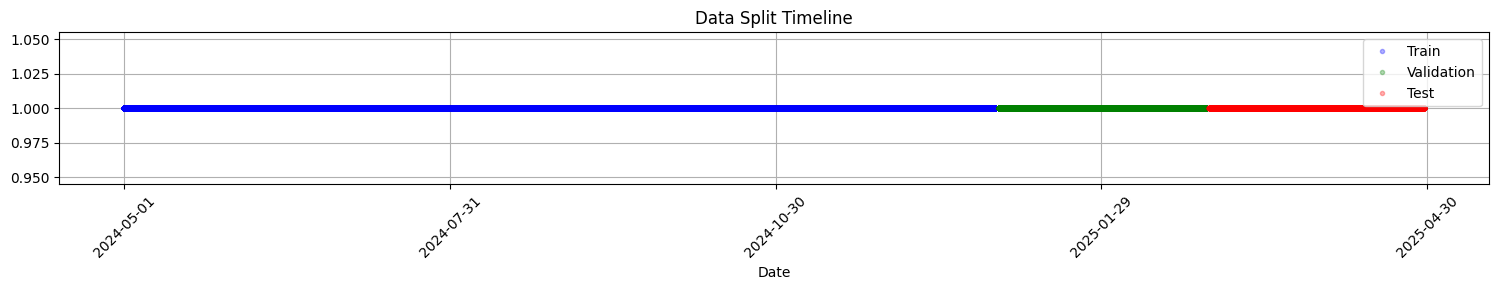

In [20]:
def annualize_factor(sampling: str):
    return ANNUALIZATION.get(sampling, 365*24)

def compute_metrics(equity_curve: pd.Series, sampling: str, turnover_series: pd.Series = None):
    ret = equity_curve.pct_change().dropna()
    ann = annualize_factor(sampling)
    
    # Return metrics
    mu = ret.mean() * ann
    sigma = ret.std() * math.sqrt(ann)
    sharpe = mu / (sigma + 1e-12)
    downside = ret[ret < 0].std() * math.sqrt(ann)
    sortino = mu / (downside + 1e-12)
    
    # Calculate CAGR
    if len(equity_curve) > 1:
        if isinstance(equity_curve.index, pd.DatetimeIndex):
            dt_years = (equity_curve.index[-1] - equity_curve.index[0]).total_seconds() / (365 * 24 * 3600)
        else:
            samples = len(equity_curve)
            samples_per_year = annualize_factor(sampling)
            dt_years = samples / samples_per_year
        dt_years = float(dt_years) if float(dt_years) != 0 else 1e-12
        cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1/dt_years) - 1
    else:
        cagr = 0.0
    
    # Drawdown metrics
    cummax = equity_curve.cummax()
    drawdown = equity_curve / cummax - 1
    maxdd = float(drawdown.min())
    avg_dd = float(drawdown.mean())
    calmar = mu / (abs(maxdd) + 1e-12)
    
    # Trading metrics
    hit_ratio = (ret > 0).mean()
    profit_factor = abs(ret[ret > 0].sum() / ret[ret < 0].sum()) if len(ret[ret < 0]) > 0 else float('inf')
    max_consecutive_losses = max(sum(1 for _ in g) for k, g in itertools.groupby(ret < 0) if k)
    turnover = turnover_series.mean() if turnover_series is not None and len(turnover_series)>0 else np.nan
    
    # Risk metrics
    var_95 = float(np.percentile(ret, 5))  # 95% VaR
    var_99 = float(np.percentile(ret, 1))  # 99% VaR
    cvar_95 = ret[ret <= var_95].mean()  # Conditional VaR (Expected Shortfall)
    
    return {
        "CAGR": cagr, 
        "Sharpe": sharpe, 
        "Sortino": sortino, 
        "MaxDrawdown": maxdd,
        "AvgDrawdown": avg_dd,
        "Calmar": calmar, 
        "Volatility": sigma,
        "VaR_95": var_95,
        "VaR_99": var_99,
        "CVaR_95": cvar_95,
        "HitRatio": hit_ratio,
        "ProfitFactor": profit_factor,
        "MaxConsecutiveLosses": max_consecutive_losses,
        "Turnover": turnover
    }

def plot_series(series: pd.Series, title: str):
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def plot_splits(time_index: pd.DatetimeIndex, train_mask: np.ndarray, val_mask: np.ndarray, test_mask: np.ndarray = None):
    """Plot timeline showing training, validation, and test periods."""
    plt.figure(figsize=(15,3))
    
    # Convert time index to numeric for plotting
    x = np.arange(len(time_index))
    
    # Plot splits
    plt.plot(x[train_mask], [1]*train_mask.sum(), 'b.', label='Train', alpha=0.3)
    plt.plot(x[val_mask], [1]*val_mask.sum(), 'g.', label='Validation', alpha=0.3)
    if test_mask is not None:
        plt.plot(x[test_mask], [1]*test_mask.sum(), 'r.', label='Test', alpha=0.3)
    
    # Set x-axis ticks to show dates
    tick_locations = np.linspace(0, len(time_index)-1, 5, dtype=int)
    plt.xticks(tick_locations, time_index[tick_locations].strftime('%Y-%m-%d'), rotation=45)
    
    plt.title("Data Split Timeline")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def backtest_env(env: gym.Env, model=None):
    # Get the unwrapped environment
    unwrapped = env.unwrapped if hasattr(env, 'unwrapped') else env
    
    obs, _ = env.reset()
    pv, turns = [], []  # Initialize lists for portfolio value and turnover
    
    for t in range(len(unwrapped.R)-1):
        if model is None:
            action = np.ones(unwrapped.dim_action)/unwrapped.dim_action
        else:
            action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, info = env.step(action)
        pv.append(info["portfolio_value"])
        turns.append(info["turnover"])
        if done:
            break
            
    idx = pd.RangeIndex(start=0, stop=len(pv), step=1)
    ec = pd.Series(pv, index=idx)
    to = pd.Series(turns, index=idx)
    
    return ec, to

# Plot data splits
print("Visualizing data splits timeline...")
plot_splits(TIME_INDEX, train_mask, val_mask, test_mask)

## Training Z-Score Environment with SAC (Online RL)

The following cells demonstrate how to train the z-score statistical arbitrage environment using Soft Actor-Critic (SAC) for online reinforcement learning.

In [21]:
# Create z-score environment for online RL training
print("="*80)
print("TRAINING Z-SCORE ENVIRONMENT WITH SAC (ONLINE RL)")
print("="*80)

# Create training environment
train_env_zscore = make_env_from_mask(train_mask, name="train_zscore")
train_env_zscore = Monitor(train_env_zscore)  # Wrap for monitoring

# Create validation environment
val_env_zscore = make_env_from_mask(val_mask, name="val_zscore")
val_env_zscore = Monitor(val_env_zscore)

# Create SAC model
print("\nInitializing SAC model...")
sac_model = SAC(
    "MlpPolicy",
    train_env_zscore,
    learning_rate=CONFIG["RL"]["learning_rate"],
    buffer_size=CONFIG["RL"]["buffer_size"],
    learning_starts=CONFIG["RL"]["learning_starts"],
    batch_size=CONFIG["RL"]["batch_size"],
    tau=CONFIG["RL"]["tau"],
    gamma=CONFIG["RL"]["gamma"],
    train_freq=CONFIG["RL"]["train_freq"],
    gradient_steps=CONFIG["RL"]["gradient_steps"],
    ent_coef=CONFIG["RL"]["ent_coef"],
    target_update_interval=CONFIG["RL"]["target_update_interval"],
    target_entropy=CONFIG["RL"]["target_entropy"],
    verbose=1,
    tensorboard_log=CONFIG["IO"]["tb_logdir"],
    device=device
)

# Setup callbacks
eval_callback = EvalCallback(
    val_env_zscore,
    best_model_save_path=os.path.join(CONFIG["IO"]["models_dir"], "zscore_best"),
    log_path=os.path.join(CONFIG["IO"]["models_dir"], "zscore_logs"),
    eval_freq=5000,
    deterministic=True,
    render=False,
    verbose=1
)

checkpoint_callback = CheckpointCallback(
    save_freq=10000,
    save_path=os.path.join(CONFIG["IO"]["models_dir"], "zscore_checkpoints"),
    name_prefix="sac_zscore"
)

# Train the model
print(f"\nTraining SAC on z-score environment for {CONFIG['RL']['total_timesteps']} timesteps...")
sac_model.learn(
    total_timesteps=CONFIG["RL"]["total_timesteps"],
    callback=[eval_callback, checkpoint_callback],
    progress_bar=True
)

# Save final model
final_model_path = os.path.join(CONFIG["IO"]["models_dir"], "sac_zscore_final")
sac_model.save(final_model_path)
print(f"\n✅ Training complete! Model saved to: {final_model_path}")

print("\n" + "="*80)
print("ONLINE RL TRAINING COMPLETED")
print("="*80)

TRAINING Z-SCORE ENVIRONMENT WITH SAC (ONLINE RL)
Action space shape: (3,)
Action space shape: (3,)
Created Z-Score StatArb environment: train_zscore
Action space shape: (3,)
Action space shape: (3,)
Created Z-Score StatArb environment: train_zscore
Action space shape: (3,)
Action space shape: (3,)
Created Z-Score StatArb environment: val_zscore

Initializing SAC model...
Using mps device
Wrapping the env in a DummyVecEnv.
Action space shape: (3,)
Action space shape: (3,)
Created Z-Score StatArb environment: val_zscore

Initializing SAC model...
Using mps device
Wrapping the env in a DummyVecEnv.

Training SAC on z-score environment for 1000 timesteps...
Logging to ./tb_logs/SAC_8

Training SAC on z-score environment for 1000 timesteps...
Logging to ./tb_logs/SAC_8


Output()


✅ Training complete! Model saved to: ./models/sac_zscore_final

ONLINE RL TRAINING COMPLETED


In [22]:
# Evaluate SAC model on all splits with optimization
def backtest_env_sac(env: gym.Env, model, verbose=True):
    """
    Backtest a SAC model on an environment with optimized inference.
    
    Args:
        env: Gymnasium environment
        model: Stable-Baselines3 SAC model
        verbose: Show progress updates
        
    Returns:
        ec: Portfolio value series
        to: Turnover series
        z_s: Z-score series
        signals: Action signal series
    """
    obs, info = env.reset()
    unwrapped = env.unwrapped if hasattr(env, 'unwrapped') else env
    
    pv, turns = [], []
    z_scores = []
    action_signals = []
    
    total_steps = len(unwrapped.R) - 1
    print_every = max(1, total_steps // 20)  # Print 20 updates
    
    if verbose:
        print(f"Backtesting {total_steps:,} timesteps...")
    
    # Use torch inference mode for faster predictions (disables gradient tracking)
    with torch.inference_mode():
        for t in range(total_steps):
            # Progress tracking
            if verbose and t % print_every == 0 and t > 0:
                pct = (t / total_steps) * 100
                print(f"  Progress: {pct:.1f}% ({t:,}/{total_steps:,})")
            
            # Get action from SAC model (deterministic for evaluation)
            action, _ = model.predict(obs, deterministic=True)
            
            obs, reward, done, trunc, info = env.step(action)
            pv.append(info["portfolio_value"])
            turns.append(info["turnover"])
            z_scores.append(info.get("z_score", 0))
            action_signals.append(info.get("action_signal", 0))
            
            if done:
                if verbose:
                    print(f"  Episode ended at step {t:,}")
                break
    
    if verbose:
        print(f"  ✓ Completed {len(pv):,} steps")
            
    idx = pd.RangeIndex(start=0, stop=len(pv), step=1)
    ec = pd.Series(pv, index=idx)
    to = pd.Series(turns, index=idx)
    z_s = pd.Series(z_scores, index=idx)
    signals = pd.Series(action_signals, index=idx)
    
    return ec, to, z_s, signals

# Evaluate on validation and test splits only (skip training set - too slow)
RESULTS_SAC = {}

print("\n" + "="*80)
print("EVALUATION ON VALIDATION SET")
print("="*80)
val_env_eval = make_env_from_mask(val_mask, name="val_eval")
ec_val, to_val, z_val, sig_val = backtest_env_sac(val_env_eval, sac_model, verbose=True)
val_metrics = compute_metrics(ec_val, CONFIG["DATA"]["sampling"], to_val)
RESULTS_SAC["validation"] = val_metrics
print(f"✓ Validation Sharpe: {val_metrics['Sharpe']:.4f}")
print(f"✓ Validation CAGR: {val_metrics['CAGR']:.4f}")
print(f"✓ Validation MaxDD: {val_metrics['MaxDrawdown']:.4f}")

print("\n" + "="*80)
print("EVALUATION ON TEST SET (Out-of-Sample)")
print("="*80)
test_env_eval = make_env_from_mask(test_mask, name="test_eval")
ec_test, to_test, z_test, sig_test = backtest_env_sac(test_env_eval, sac_model, verbose=True)
test_metrics = compute_metrics(ec_test, CONFIG["DATA"]["sampling"], to_test)
RESULTS_SAC["test"] = test_metrics
print(f"✓ Test Sharpe: {test_metrics['Sharpe']:.4f}")
print(f"✓ Test CAGR: {test_metrics['CAGR']:.4f}")
print(f"✓ Test MaxDD: {test_metrics['MaxDrawdown']:.4f}")

# Display results
print("\n" + "="*80)
print("SAC Z-SCORE RESULTS SUMMARY")
print("="*80)
print("(Training set evaluation skipped to save time)")

results_df = pd.DataFrame(RESULTS_SAC).T
key_metrics = ['Sharpe', 'CAGR', 'MaxDrawdown', 'Volatility', 'Turnover', 'HitRatio']
display(results_df[key_metrics].style.format("{:.4f}"))


EVALUATION ON VALIDATION SET
Action space shape: (3,)
Action space shape: (3,)
Created Z-Score StatArb environment: val_eval
Backtesting 237,048 timesteps...
Action space shape: (3,)
Action space shape: (3,)
Created Z-Score StatArb environment: val_eval
Backtesting 237,048 timesteps...
  Progress: 5.0% (11,852/237,048)
  Progress: 5.0% (11,852/237,048)
  Progress: 10.0% (23,704/237,048)
  Progress: 10.0% (23,704/237,048)
  Progress: 15.0% (35,556/237,048)
  Progress: 15.0% (35,556/237,048)
  Progress: 20.0% (47,408/237,048)
  Progress: 20.0% (47,408/237,048)
  Progress: 25.0% (59,260/237,048)
  Progress: 25.0% (59,260/237,048)
  Progress: 30.0% (71,112/237,048)
  Progress: 30.0% (71,112/237,048)
  Progress: 35.0% (82,964/237,048)
  Progress: 35.0% (82,964/237,048)
  Progress: 40.0% (94,816/237,048)
  Progress: 40.0% (94,816/237,048)
  Progress: 45.0% (106,668/237,048)
  Progress: 45.0% (106,668/237,048)
  Progress: 50.0% (118,520/237,048)
  Progress: 50.0% (118,520/237,048)
  Progress

,Sharpe,CAGR,MaxDrawdown,Volatility,Turnover,HitRatio
validation,-22.9909,-1.0000,-1.0000,8.9177,0.6097,0.1701
test,-83.4140,-1.0000,-1.0000,2.4331,0.6057,0.1690


In [23]:
# Verify model device and optimize for inference
print("Model device:", sac_model.device)
print("Policy device:", sac_model.policy.device)
# print(f"Number of training timesteps in train set: {len(train_env_eval.unwrapped.R) - 1}")
print(f"Number of training timesteps in val set: {len(val_env_zscore.unwrapped.R) - 1}")
print(f"Number of training timesteps in test set: {len(make_env_from_mask(test_mask, 'temp').R) - 1}")
print("\nNote: Training set evaluation will take longer due to more timesteps.")

Model device: mps
Policy device: mps:0
Number of training timesteps in val set: 237048
Action space shape: (3,)
Action space shape: (3,)
Created Z-Score StatArb environment: temp
Number of training timesteps in test set: 234191

Note: Training set evaluation will take longer due to more timesteps.
Action space shape: (3,)
Action space shape: (3,)
Created Z-Score StatArb environment: temp
Number of training timesteps in test set: 234191

Note: Training set evaluation will take longer due to more timesteps.


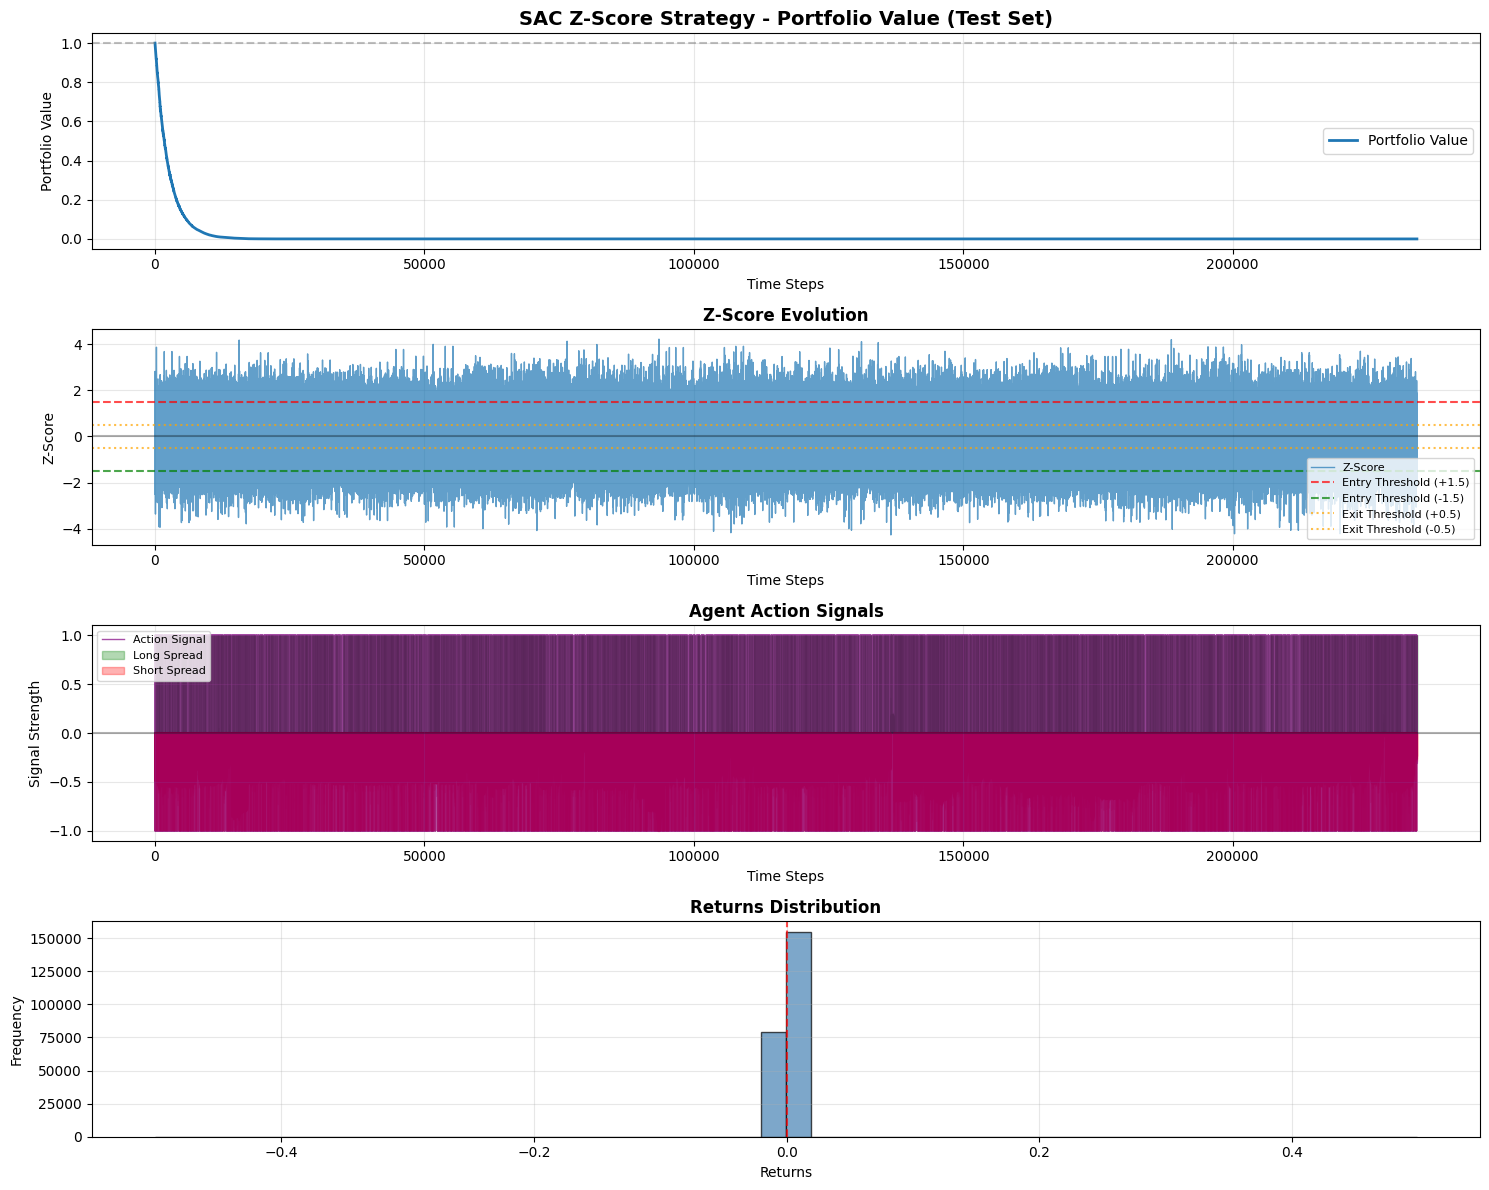


Final Test Sharpe Ratio: -83.4140
Test CAGR: -100.00%
Max Drawdown: -100.00%


In [24]:
# Visualize SAC performance with Z-scores
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Plot 1: Equity Curve
axes[0].plot(ec_test.values, label='Portfolio Value', linewidth=2)
axes[0].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_title('SAC Z-Score Strategy - Portfolio Value (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Portfolio Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Z-Scores with threshold lines
axes[1].plot(z_test.values, label='Z-Score', alpha=0.7, linewidth=1)
axes[1].axhline(y=1.5, color='red', linestyle='--', label='Entry Threshold (+1.5)', alpha=0.7)
axes[1].axhline(y=-1.5, color='green', linestyle='--', label='Entry Threshold (-1.5)', alpha=0.7)
axes[1].axhline(y=0.5, color='orange', linestyle=':', label='Exit Threshold (+0.5)', alpha=0.7)
axes[1].axhline(y=-0.5, color='orange', linestyle=':', label='Exit Threshold (-0.5)', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].set_title('Z-Score Evolution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Z-Score')
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(True, alpha=0.3)

# Plot 3: Action Signals
axes[2].plot(sig_test.values, label='Action Signal', alpha=0.7, linewidth=1, color='purple')
axes[2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[2].fill_between(range(len(sig_test)), 0, sig_test.values, 
                      where=(sig_test.values > 0), alpha=0.3, color='green', label='Long Spread')
axes[2].fill_between(range(len(sig_test)), 0, sig_test.values, 
                      where=(sig_test.values < 0), alpha=0.3, color='red', label='Short Spread')
axes[2].set_title('Agent Action Signals', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time Steps')
axes[2].set_ylabel('Signal Strength')
axes[2].legend(loc='best', fontsize=8)
axes[2].grid(True, alpha=0.3)

# Plot 4: Returns Distribution
returns = ec_test.pct_change().dropna()
axes[3].hist(returns, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[3].axvline(x=0, color='red', linestyle='--', alpha=0.7)
axes[3].set_title('Returns Distribution', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Returns')
axes[3].set_ylabel('Frequency')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Test Sharpe Ratio: {test_metrics['Sharpe']:.4f}")
print(f"Test CAGR: {test_metrics['CAGR']*100:.2f}%")
print(f"Max Drawdown: {test_metrics['MaxDrawdown']*100:.2f}%")